In [1]:
function ntrp3h(tint,t,y,yp,tnew,ynew,ypnew)
    # Hermite extrapolation
    h     = tnew - t;
    s     = (tint - t)/h;
    s2    = s * s;
    s3    = s * s2;
    slope = (ynew - y)/h;
    c     = 3*slope - 2*yp - ypnew;
    d     = yp + ypnew - 2*slope;
    
    return y + (h*d*s3 + h*c*s2 + h*yp*s);           
end

function int_simpson(h, y_begin, y_end, y_half)
    # Simpson's method
    return h/6*(y_begin + 4*y_half + y_end);
end

function ide_delay_rk(idefun,Core,delays,history,tspan,step)
    #  idefun - right-hand side function
    #    Core - Kernel (integrated function)
    #  delays - delays function (lower integration limit)
    # History - history function
    #   tspan - solution interval
    #    step - step-size
      
    t0   = tspan[1];    # t begin
    tf   = tspan[2];    # t end
    y0   = history(t0); # initial solution
    neq  = length(y0);  # number of equations
    htry = step;        # constant mesh step-size
    h    = htry;        # current step-size (for the last step)
    #==============================================================#
    # VIDE Runge-Kutta Bel'tyukov-type of Order 4
    A = [0 1/2   0  0
         0   0 1/2  0 
         0   0   0  1     
         0   0   0  0 ];
    
    b = [1/6; 1/3; 1/3; 1/6];
    s = length(b);
    c = [0 1/2 1/2 1];
    d = [1/2; 1/2; 1];
    #==============================================================#
    # Calculate integral (F) in history
    F = zeros(neq);
    
    # Piece from delays(t0) to the next mesh point
    # tj, tj_half, tj_1, Core_tj, Core_tj_1, Core_tj_h are always needed
    # to use Simpson's Method for numerical approximations of integrals
    tj      = delays(t0);             # Begin
    step    = trunc(Int,(t0 - tj)/h); # The number of memorized 
                                      # intervals of history
    tj_1    = t0 - step*h;            # End
    tj_half = (tj+tj_1)/2;            # Half segment

    # Calculate Kernel values at the nodes
    Core_tj   = Core(t0,tj, history(tj));
    Core_tj_1 = Core(t0,tj_1, history(tj_1));
    Core_tj_h = Core(t0,tj_half, history(tj_half));

    # Simpson's method
    F   = F + ones(neq).*int_simpson(tj_1-tj,Core_tj,Core_tj_1,Core_tj_h);

    # Main integral over the mesh points
    Core_tj = Core_tj_1;
    for j = step-1:-1:0
        tj_1      = t0 - j*h;
        tj_half   = tj_1 - h/2;
               
        # Calculate Kernel values at the nodes
        Core_tj_h = Core(t0,tj_half, history(tj_half));
        Core_tj_1 = Core(t0,tj_1, history(tj_1));

        # Simpson's method
        F         = F + ones(neq).*int_simpson(h,Core_tj,Core_tj_1,Core_tj);

        # Kernel of tj_1 is equal to tj of the next step
        Core_tj   = Core_tj_1;
    end
    #==============================================================#
    # Initialization | First Step | Y | K
    t      = t0; 
    y      = zeros(neq,1);
    y[:,1] = ones(neq).*y0;
    k      = 1;  # step
    
    Y        = zeros(neq,s);
    K        = zeros(neq,s,1);
    K[:,1,k] = idefun(t[k],y[:,1],F);
    Core_di  = zeros(neq,s);
    #==============================================================#
    
    while t[k] < tf
        #==========================================================#
        # Last step
        if t[k] + h > tf
            h = tf - t[k];
        end
        #==========================================================#
        Z      = zeros(neq,s);
        Y[:,1] = y[:,k];
        
        # Runge-Kutta steps
        for i = 2 : s
            ti = t[k] + c[i]*h;
            #======================================================#
            # Calculate integral (F)
            if i != 3 # c[3] = c[2] so the same F value is used
                F = zeros(neq);
                
                dtk_begin = delays(ti); # lower integration limit
                if dtk_begin < t0
                    #==============================================#
                    # Integral begins in the history
                    
                    # Step of delays(ti) in the history
                    step = trunc(Int,(t0 - dtk_begin)/h); 
                    
                    # Add piece from dtk_begin to the next mesh point in the history
                    tj        = dtk_begin;
                    tj_1      = t0-step*htry;
                    tj_half   = (tj+tj_1)/2;
                    
                    # Calculate Kernel values at the nodes
                    Core_tj   = Core(ti,tj, history(tj));
                    Core_tj_1 = Core(ti,tj_1, history(tj_1));
                    Core_tj_h = Core(ti,tj_half, history(tj_half));
                    
                    # Simpson's method
                    F = F + ones(neq).*int_simpson(tj_1-tj,Core_tj,Core_tj_1,Core_tj_h);
                    
                    # Main integral in the history
                    Core_tj = Core_tj_1;
                    for j = step-1:-1:0
                        tj_1      = t0 - j*htry;
                        tj_half   = tj_1 - htry/2;
                        
                        # Calculate Kernel values at the nodes
                        Core_tj_1 = Core(ti,tj_1, history(tj_1));
                        Core_tj_h = Core(ti,tj_half, history(tj_half));

                        # Simpson's method
                        F = F + ones(neq).*int_simpson(htry,Core_tj,Core_tj_1,Core_tj_h);
                        
                        # Kernel of tj_1 is equal to tj of the next step 
                        Core_tj   = Core_tj_1;
                    end
                    
                    # Add integral in the solution to t(k)
                    for j = 2:k
                        tj_half   = t[j] - h/2;
                        y_half    = ntrp3h(tj_half,t[j-1],y[:,j-1],K[:,1,j-1],
                                                   t[j],y[:,j],K[:,1,j]);
                        
                        # Calculate Kernel values at the nodes
                        if neq == 1
                            Core_tj_h = Core(ti,tj_half, y_half[1]);
                            Core_tj_1 = Core(ti,t[j], y[1,j]);
                        else
                            Core_tj_h = Core(ti,tj_half, y_half);
                            Core_tj_1 = Core(ti,t[j], y[:,j]);
                        end

                        # Simpson's method
                        F = F + ones(neq).*int_simpson(htry,Core_tj,Core_tj_1,Core_tj_h);

                        # Kernel of tj_1 is equal to tj of the next step 
                        Core_tj   = Core_tj_1;
                    end
                    #==============================================#
                else
                    #==============================================#
                    # Integral only over the solution
                    
                    # Step of delays(ti) in the solution
                    step      = trunc(Int,(dtk_begin-t0)/htry + 1);
                    
                    # Add piece from dtk_begin to the mesh point in the solution
                    tj_half   = (t[step+1] + dtk_begin)/2;
                    
                    y_begin   = ntrp3h(dtk_begin,t[step],y[:,step],K[:,1,step],
                                           t[step+1],y[:,step+1],K[:,1,step+1]);
                    y_begin_h = ntrp3h(tj_half,t[step],y[:,step],K[:,1,step],
                                           t[step+1],y[:,step+1],K[:,1,step+1]);
                    
                    # Calculate Kernel values at the nodes
                    if neq == 1
                        Core_tj   = Core(ti,dtk_begin, y_begin[1]);
                        Core_tj_1 = Core(ti,t[step+1], y[1,step+1]);
                        Core_tj_h = Core(ti,tj_half, y_begin_h[1]);
                    else
                        Core_tj   = Core(ti,dtk_begin, y_begin);
                        Core_tj_1 = Core(ti,t[step+1], y[:,step+1]);
                        Core_tj_h = Core(ti,tj_half, y_begin_h);
                    end
                        
                    # Simpson's method
                    F = F + ones(neq).*int_simpson(t[step+1]-dtk_begin,Core_tj,
                                                  Core_tj_1,Core_tj_h);
                
                    # Main integral to t(k)
                    Core_tj = Core_tj_1;
                    for j = step+2:k
                        tj_half   = t[j] - htry/2;
                        y_half    = ntrp3h(tj_half,t[j-1],y[:,j-1],K[:,1,j-1],
                                                   t[j],y[:,j],K[:,1,j]);
                        
                        # Calculate Kernel values at the nodes
                        if neq == 1
                            Core_tj_h = Core(ti,tj_half, y_half[1]);
                            Core_tj_1 = Core(ti,t[j], y[1,j]);
                        else
                            Core_tj_h = Core(ti,tj_half, y_half);
                            Core_tj_1 = Core(ti,t[j], y[:,j]);
                        end

                        # Simpson's method
                        F = F + ones(neq).*int_simpson(htry,Core_tj,Core_tj_1,Core_tj_h);

                        # Kernel of tj_1 is equal to tj of the next step 
                        Core_tj   = Core_tj_1;
                    end
                    #==============================================#
                end
            end
            #======================================================#
            #println("i = ",i)
            # Y2-4
            Y[:,i] = y[:,k] + h * (K[:,1:i-1,k] * A[1:i-1,i]);
            
            # Z2-4
            if neq == 1
                Core_di[1,i-1] = Core(t[k]+d[i-1]*h,t[k]+c[i-1]*h,Y[1,i-1]);
            else
                Core_di[:,i-1] = Core(t[k]+d[i-1]*h,t[k]+c[i-1]*h,Y[:,i-1]);
            end
            Z[:,i]         = h * (Core_di[:,1:i-1] * A[1:i-1,i]);
            
            # K2-4
            K[:, i, k] = idefun(ti, Y[:,i], F+Z[:,i]);
        end
        #==========================================================#
        # Final approximation of RK Method
        t = [t; t[k] + h];
        y = [y y[:,k] + h * ( K[:,:,k] * b )];
        #==========================================================#
        # Calculate K(1) for next step
        # Hermite extrapolation for K(1,k+1)
        y_k_half     = 3/4*y[:,k] + 1/4*y[:,k+1] + h/4*K[:,1,k];
        if neq == 1
            Core_tk_half = Core(t[k+1], t[k]+h/2, y_k_half[1]);
            Core_tk      = Core(t[k+1], t[k+1], y[1,k+1]);
        else
            Core_tk_half = Core(t[k+1], t[k]+h/2, y_k_half);
            Core_tk      = Core(t[k+1], t[k+1], y[:,k+1]);
        end
        
        F  = F + ones(neq).*int_simpson(h,Core_tj,Core_tk,Core_tk_half);
        K1 = zeros(neq,s,1);
        K  = cat(K, K1, dims=3);
        K[:,1,k+1] = idefun(t[k+1], y[:,k+1], F);
        
        k = k + 1;
    end
    return t, y';
end

ide_delay_rk (generic function with 1 method)

In [2]:
using Plots

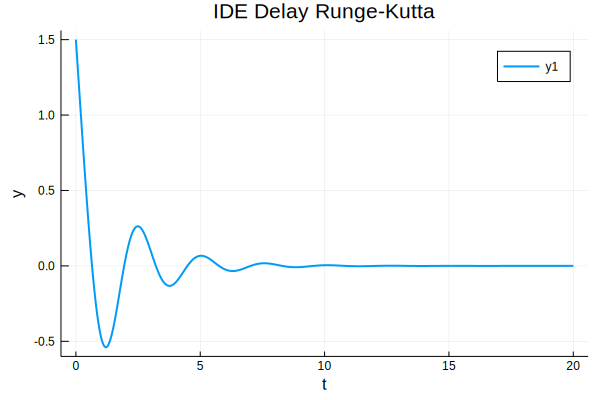

In [3]:
tspan = [0 20];
idefun(t,y,int) = -2.5*int;
K(t,s,y)        = sin(y); 
delays(t)       = t-1;
history(t)     = 1.5;

sol = ide_delay_rk(idefun,K,delays,history,tspan,1e-3);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

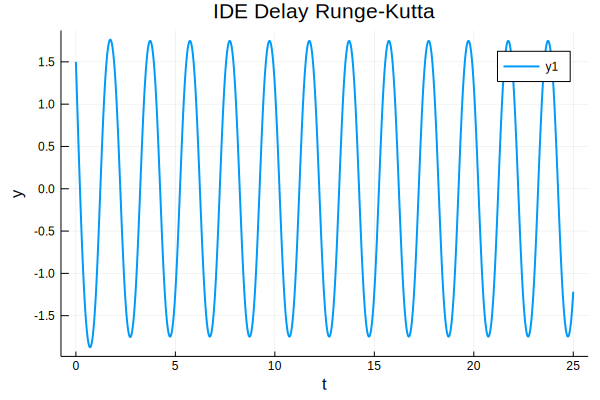

In [4]:
tspan = [0 25];
idefun(t,y,int) = -7.5*int;
K(t,s,y)        = sin(y); 
delays(t)       = t-1;
history(t)     = 1.5;

sol = ide_delay_rk(idefun,K,delays,history,tspan,1e-3);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

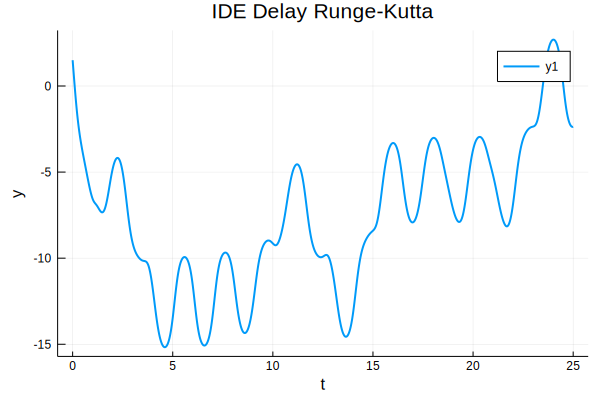

In [5]:
tspan = [0 25];
idefun(t,y,int) = -15*int;
K(t,s,y)        = sin(y); 
delays(t)       = t-1;
history(t)     = 1.5;

sol = ide_delay_rk(idefun,K,delays,history,tspan,1e-3);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

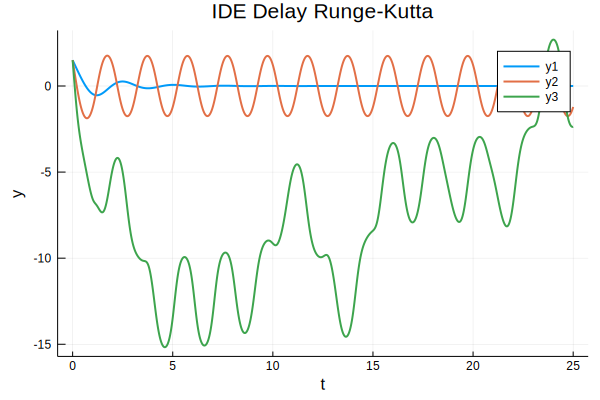

In [8]:
tspan = [0 25];
idefun(t,y,int) = [ -2.5*int[1];
                    -7.5*int[2];
                     -15*int[3] ]
K(t,s,y)        = [ sin(y[1]);
                    sin(y[2]);
                    sin(y[3]) ];
delays(t)       = t-1;
history(t)     = [ 1.5;
                    1.5;
                    1.5 ];

sol = ide_delay_rk(idefun,K,delays,history,tspan,1e-3);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")

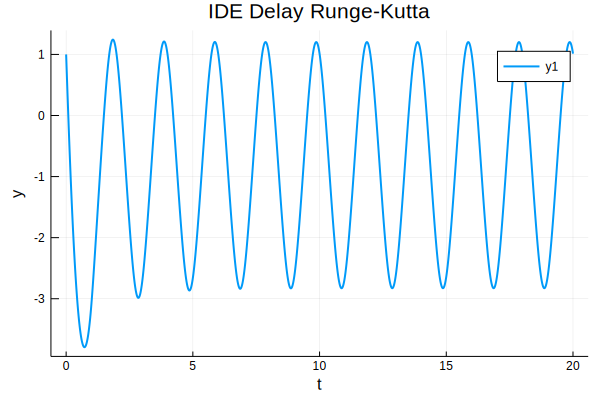

In [7]:
tspan = [0 20];
idefun(t,y,int) = -int;
r = 7;
K(t,s,y)        = r*(exp(y)-1); 
delays(t)       = t-1;
history(t)     = 1;

sol = ide_delay_rk(idefun,K,delays,history,tspan,1e-2);

# Output vector of times t
# Output vector of solutions y
#print(sol[1])
#print(sol[2])

# create a line plot
plot(sol, linewidth=2, xlabel="t", ylabel="y", title="IDE Delay Runge-Kutta")